# Kaplan-Meier

/home/vlady/Documents/Projects/vzahorui.github.io/.pixi/envs/default/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


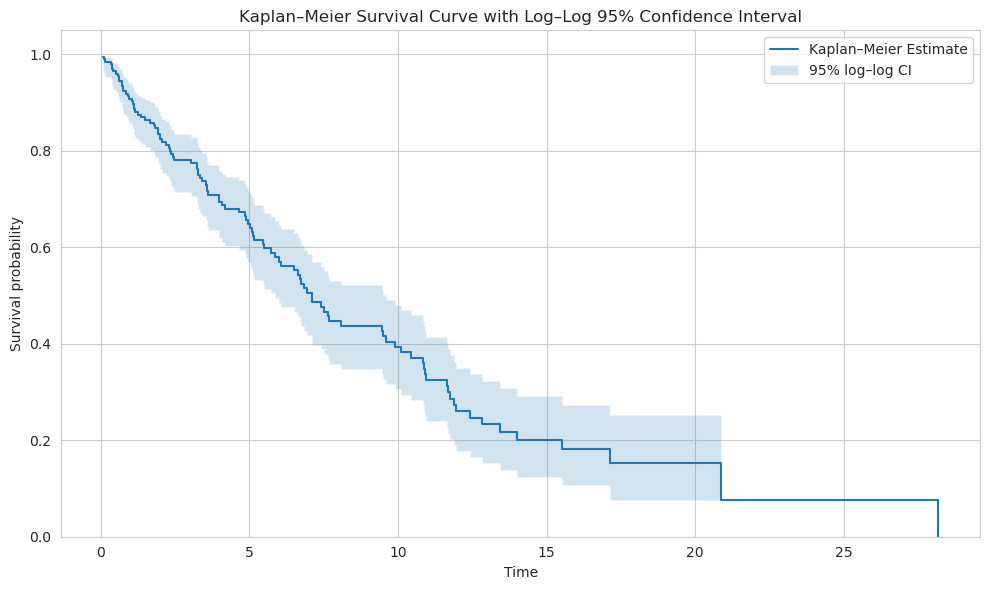

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

rng = np.random.default_rng(42)
N = 200                     # number of subjects
true_lambda = 0.1           # true hazard rate
censoring_time = rng.exponential(scale=12, size=N)
survival_time = rng.exponential(scale=1/true_lambda, size=N)

# Observed time and censoring indicator
time = np.minimum(survival_time, censoring_time)
event = (survival_time <= censoring_time).astype(int)

data = pd.DataFrame({'time': time, 'event': event}).sort_values('time')

event_times = np.sort(data.loc[data['event'] == 1, 'time'].unique())

n = []  # number at risk
d = []  # number of events

n_risk = len(data)
idx = 0

for t in event_times:
    d_i = np.sum((data['time'] == t) & (data['event'] == 1))
    n_i = np.sum(data['time'] >= t)
    n.append(n_i)
    d.append(d_i)

km_df = pd.DataFrame({'time': event_times, 'n_i': n, 'd_i': d})

# Kaplan-Meier survival estimate
km_df['survival'] = (1 - km_df['d_i'] / km_df['n_i']).cumprod()

# Greenwood’s variance (log–log CI uses this)
km_df['V'] = np.cumsum(km_df['d_i'] / (km_df['n_i'] * (km_df['n_i'] - km_df['d_i'])))
km_df['var'] = (km_df['survival'] ** 2) * km_df['V']

z = norm.ppf(0.975)  # 95% CI

S = km_df['survival']
V = km_df['V']
logS = np.log(S)
loglogS = np.log(-logS)

se_loglog = np.sqrt(V) / np.abs(logS)

upper_loglog = loglogS - z * se_loglog
lower_loglog = loglogS + z * se_loglog

km_df['ci_lower'] = np.exp(-np.exp(lower_loglog))
km_df['ci_upper'] = np.exp(-np.exp(upper_loglog))

with sns.axes_style("whitegrid"):
    plt.figure(figsize=(10, 6))

    plt.step(km_df['time'], km_df['survival'], where='post', label='Kaplan–Meier Estimate')
    plt.fill_between(
        km_df['time'],
        km_df['ci_lower'],
        km_df['ci_upper'],
        step='post',
        alpha=0.2,
        label='95% log–log CI'
    )
    plt.xlabel('Time')
    plt.ylabel('Survival probability')
    plt.title('Kaplan–Meier Survival Curve with Log–Log 95% Confidence Interval')
    plt.ylim(0, 1.05)
    plt.legend()
    plt.tight_layout()
    plt.savefig('../../assets/images/survival_analysis/kaplan_meier.png', bbox_inches='tight')
    plt.show()


# Hazard Functions: Parametric Weibull vs Semi-parametric Cox PH

Weibull estimates: lambda=0.0138, k=1.8732, beta=1.6152
Cox estimate: beta=0.4701


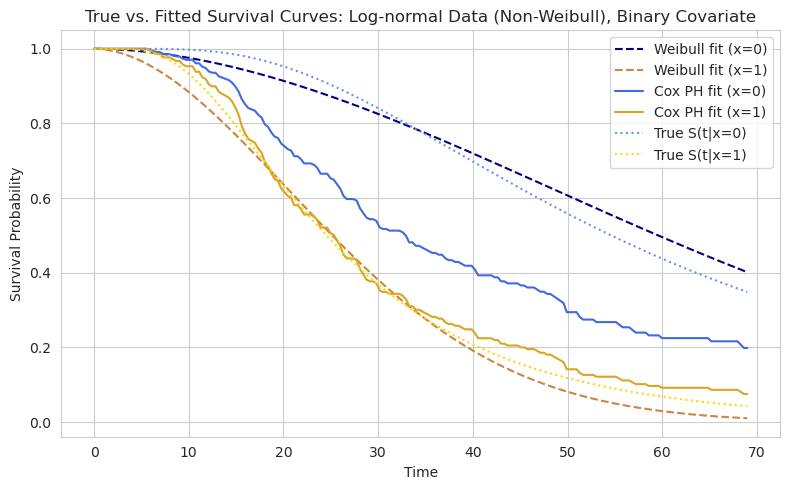

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize
from scipy.stats import lognorm

np.random.seed(42)

# === Simulate survival data from log-normal baseline (non-Weibull) ===
n = 400
beta_true = 0.8
mu_true, sigma_true = 4.0, 0.6  # log-normal parameters

x = np.random.binomial(1, 0.5, size=n)
z = np.random.normal(size=n)
# Log-normal survival times (baseline = exp(mu + sigma*z))
t = np.exp(mu_true + sigma_true * z - beta_true * x)
censoring_time = np.random.exponential(scale=np.exp(mu_true + sigma_true**2 / 2) * 0.8, size=n)
observed_time = np.minimum(t, censoring_time)
event = (t <= censoring_time).astype(int)
df = pd.DataFrame({"time": observed_time, "event": event, "x": x})

# === Weibull MLE fitting (incorrect baseline) ===
def weibull_neg_log_likelihood(params, t, event, x):
    log_lambda, log_k, beta = params
    lam, k = np.exp(log_lambda), np.exp(log_k)
    risk = np.exp(beta * x)
    loglik = (
        event * (np.log(k) + k * np.log(lam) + (k - 1) * np.log(t) + np.log(risk))
        - (lam * t) ** k * risk
    )
    return -np.sum(loglik)

init_params = [np.log(0.01), np.log(1.0), 0.0]
res_wb = minimize(weibull_neg_log_likelihood, init_params, args=(df["time"], df["event"], df["x"]))
log_lambda_hat, log_k_hat, beta_hat_wb = res_wb.x
lambda_hat, k_hat = np.exp(log_lambda_hat), np.exp(log_k_hat)

print(f"Weibull estimates: lambda={lambda_hat:.4f}, k={k_hat:.4f}, beta={beta_hat_wb:.4f}")

# === Cox PH estimation via partial likelihood ===
def cox_partial_loglik(beta, t, event, x):
    order = np.argsort(t)
    t, event, x = t[order], event[order], x[order]
    loglik = 0.0
    for i in range(len(t)):
        if event[i] == 1:
            risk_set = np.where(t >= t[i])[0]
            loglik += beta * x[i] - np.log(np.sum(np.exp(beta * x[risk_set])))
    return -loglik

res_cox = minimize(cox_partial_loglik, 0.0, args=(df["time"], df["event"], df["x"]))
beta_hat_cox = res_cox.x[0]
print(f"Cox estimate: beta={beta_hat_cox:.4f}")

# === Estimate baseline cumulative hazard H0(t) via Nelson–Aalen ===
df_sorted = df.sort_values("time")
risk_counts = np.array([np.sum(df_sorted["time"] >= t) for t in df_sorted["time"]])
H0 = np.cumsum(df_sorted["event"] / risk_counts)
df_sorted["H0"] = H0

# === Compute survival curves ===
times = np.linspace(0, np.percentile(df["time"], 95), 200)

# True survival under log-normal model
S_true_x0 = 1 - lognorm.cdf(times, s=sigma_true, scale=np.exp(mu_true))
S_true_x1 = 1 - lognorm.cdf(times * np.exp(beta_true), s=sigma_true, scale=np.exp(mu_true))

# Weibull fitted
S_wb_x0 = np.exp(-((lambda_hat * times) ** k_hat))
S_wb_x1 = np.exp(-((lambda_hat * times) ** k_hat) * np.exp(beta_hat_wb))

# Cox fitted (Nelson–Aalen baseline)
def interpolate_H0(time):
    idx = np.searchsorted(df_sorted["time"], time, side="right") - 1
    idx = np.clip(idx, 0, len(df_sorted) - 1)
    return df_sorted["H0"].iloc[idx]

S_cox_x0 = np.exp(-np.array([interpolate_H0(ti) for ti in times]))
S_cox_x1 = np.exp(-np.array([interpolate_H0(ti) for ti in times]) * np.exp(beta_hat_cox))

with sns.axes_style("whitegrid"):
    plt.figure(figsize=(8, 5))
    sns.lineplot(x=times, y=S_wb_x0, label="Weibull fit (x=0)", linestyle="--", color='navy')
    sns.lineplot(x=times, y=S_wb_x1, label="Weibull fit (x=1)", linestyle="--", color='peru')
    sns.lineplot(x=times, y=S_cox_x0, label="Cox PH fit (x=0)", color="royalblue")
    sns.lineplot(x=times, y=S_cox_x1, label="Cox PH fit (x=1)", color="goldenrod")
    sns.lineplot(x=times, y=S_true_x0, label="True S(t|x=0)", linestyle=":", color='cornflowerblue')
    sns.lineplot(x=times, y=S_true_x1, label="True S(t|x=1)", color="gold", linestyle=":")
    
    plt.title("True vs. Fitted Survival Curves: Log-normal Data (Non-Weibull), Binary Covariate")
    plt.xlabel("Time")
    plt.ylabel("Survival Probability")
    plt.tight_layout()
    plt.legend()
    plt.savefig('../../assets/images/survival_analysis/cox_vs_weibull.png', bbox_inches='tight');


In [22]:
np.exp(-1)

np.float64(0.36787944117144233)

In [24]:
np.exp(-np.exp(0.4701))

np.float64(0.2018653878231966)